# AMP-SDP vs Shuffle DP vs Network Shuffling
# Mean Estimation under Output Poisoning Attack (OPA)

This notebook compares the robustness of three privacy mechanisms:
- AMP-SDP (Ours)
- Standard Shuffle DP (see Wang et al. VLDB'24)
- Network Shuffling $$(ε' \approx e^{1.5ε₀}/√n)$$ (see Liew et al. SIGMOD'22)

in the face of output poisoning attacks under a mean estimation task.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

# Global Parameters
n = 10000
epsilon_primes = [0.5, 1.0]
delta = 1e-5
beta = 0.5
gamma_values = np.linspace(0, 0.3, 10)
num_trials = 100
true_mean = 0.5

# Function to derive true epsilon_0 from epsilon'
def compute_epsilon_0(epsilon_prime, beta, delta, n):
    def loss(eps0):
        p = np.exp(eps0)
        rhs = np.sqrt((beta * (p - 1) * np.log(1 / delta)) / n)
        return (rhs - epsilon_prime) ** 2
    return minimize_scalar(loss, bounds=(0.01, 10), method='bounded').x

# Mechanism implementations

def evaluate_amp_sdp_mean(n, epsilon, gamma):
    n_corrupt = int(gamma * n)
    n_honest = n - n_corrupt
    honest_data = np.random.uniform(0, 1, n_honest)
    # IPA only: corrupt raw input in [0, 1]
    corrupt_data = np.ones(n_corrupt)
    combined = np.concatenate([honest_data, corrupt_data])
    noise = np.random.laplace(loc=0, scale=1/epsilon, size=n)
    return np.mean(combined + noise)

def evaluate_shuffle_dp_mean(n, epsilon, gamma):
    n_corrupt = int(gamma * n)
    n_honest = n - n_corrupt
    honest_data = np.random.uniform(0, 1, n_honest)
    # OPA: submit maximum possible output
    poison_value = 1 + 5 / epsilon
    corrupt_data = np.full(n_corrupt, poison_value)
    combined = np.concatenate([honest_data, corrupt_data])
    noise = np.random.laplace(loc=0, scale=1/epsilon, size=n)
    return np.mean(combined + noise)

In [6]:
# Simulation wrapper
def run_experiment(epsilon_prime, variant="shuffle"):
    if variant == "network":
        def loss(eps0):
            lhs = np.exp(1.5 * eps0) / np.sqrt(n)
            return (lhs - epsilon_prime) ** 2
        eps0 = minimize_scalar(loss, bounds=(0.01, 10), method='bounded').x
    else:
        eps0 = compute_epsilon_0(epsilon_prime, beta, delta, n)
    
    # Begin robustness evaluation
    results = []
    for gamma in gamma_values:
        estimates = []
        for _ in range(num_trials):
            if variant == "shuffle":
                est = evaluate_shuffle_dp_mean(n, eps0, gamma)
            elif variant == "network":
                est = evaluate_shuffle_dp_mean(n, 1.5*eps0, gamma)
            elif variant == "amp":
                est = evaluate_amp_sdp_mean(n, eps0, gamma)
            estimates.append(est)
        mean = np.mean(estimates)
        std = np.std(estimates)
        results.append((gamma, mean, mean - 2*std, mean + 2*std))
    return np.array(results)

# Plotting

def plot_all():
    print("Evaluating mean estimation robustness under OPA...")
    for eps_prime in epsilon_primes:
        plt.figure(figsize=(7, 4))
        for variant, color, label in zip(["amp", "shuffle", "network"], ["green", "blue", "orange"], ["AMP-SDP", "Shuffle DP", "Network Shuffling"]):
            data = run_experiment(eps_prime, variant)
            plt.plot(data[:, 0], data[:, 1], label=label, color=color)
            plt.fill_between(data[:, 0], data[:, 2], data[:, 3], alpha=0.2, color=color)
        plt.axhline(true_mean, color='black', linestyle='--', label="True Mean")
        plt.title(f"Mean Estimation under OPA (ε′ = {eps_prime})")
        plt.xlabel("Corruption Ratio γ")
        plt.ylabel("Estimated Mean")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

Evaluating mean estimation robustness under OPA...


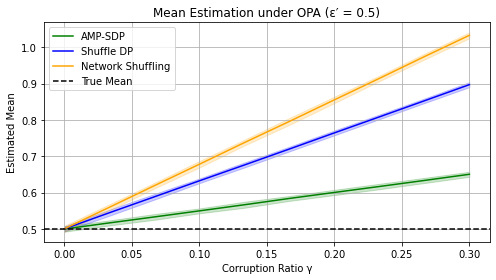

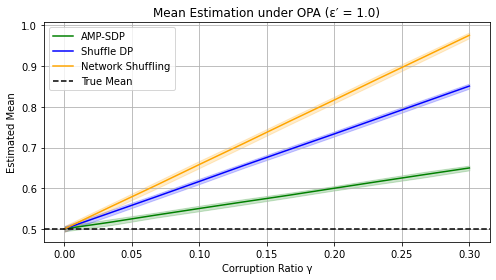

In [7]:
plot_all()

# Conclusion

"""
This study compares the robustness of AMP-SDP, Shuffle DP, and Network Shuffling under output poisoning attacks in a mean estimation task.

Key Observations:
- **AMP-SDP** offers strong robustness since users can only influence raw data, and noise/randomization is securely handled post-shuffle.
- **Shuffle DP** is more vulnerable to OPA, especially at higher corruption ratios, as attackers can directly manipulate noisy outputs.
- **Network Shuffling** provides less robustness: it benefits from ε-amplification, but is less optimal. The vulnerability to OPA remains due to the open input interface.

These results highlight the structural benefit of separating raw data from randomized output, as done in AMP-SDP, in resisting poisoning-based manipulation.
"""

# AMP-SDP vs Shuffle DP vs Network Shuffling
# Mean Estimation and Frequency Estimation under Output Poisoning Attack (OPA)

This notebook compares the robustness of three privacy mechanisms:
- AMP-SDP
- Standard Shuffle DP
- Network Shuffling (ε' = e^{1.5ε₀}/√n)

in the face of output poisoning attacks under both **mean estimation** and **frequency estimation (kRR)** tasks.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

# Global Parameters
n = 10000
k = 20
true_distribution = np.ones(k) / k  # Uniform distribution
epsilon_primes = [0.5, 1.0]
delta = 1e-5
beta = 0.5
gamma_values = np.linspace(0, 0.3, 10)
num_trials = 10
target_bin = 0

# Compute true epsilon_0 from epsilon'
def compute_epsilon_0(epsilon_prime, beta, delta, n):
    def loss(eps0):
        p = np.exp(eps0)
        rhs = np.sqrt((beta * (p - 1) * np.log(1 / delta)) / n)
        return (rhs - epsilon_prime) ** 2
    return minimize_scalar(loss, bounds=(0.01, 10), method='bounded').x

# Frequency Estimation under OPA

def krr_probs(k, epsilon):
    p = np.exp(epsilon) / (np.exp(epsilon) + k - 1)
    q = (1 - p) / (k - 1)
    return p, q

def evaluate_krr_shuffle_dp(n, epsilon, gamma, k, true_dist, target_bin):
    # Shuffle DP or Network Shuffle: allows OPA
    p, q = krr_probs(k, epsilon)
    n_corrupt = int(gamma * n)
    n_honest = n - n_corrupt
    honest_data = np.random.choice(k, size=n_honest, p=true_dist)

    # Apply kRR for honest users
    reports = []
    for x in honest_data:
        probs = np.full(k, q)
        probs[x] = p
        reports.append(np.random.choice(k, p=probs))

    # OPA: corrupted users directly report target bin
    reports += [target_bin] * n_corrupt
    reports = np.array(reports)

    # Frequency estimator
    est_freq = (np.sum(reports == target_bin) / n - q) / (p - q)
    return np.clip(est_freq, 0, 1)

def evaluate_krr_amp_sdp(n, epsilon, gamma, k, true_dist, target_bin):
    # AMP-SDP: only IPA
    p, q = krr_probs(k, epsilon)
    n_corrupt = int(gamma * n)
    n_honest = n - n_corrupt
    honest_data = np.random.choice(k, size=n_honest, p=true_dist)
    corrupt_data = np.full(n_corrupt, target_bin)  # raw inputs only
    combined_data = np.concatenate([honest_data, corrupt_data])

    # Apply kRR
    reports = []
    for x in combined_data:
        probs = np.full(k, q)
        probs[x] = p
        reports.append(np.random.choice(k, p=probs))

    reports = np.array(reports)
    est_freq = (np.sum(reports == target_bin) / n - q) / (p - q)
    return np.clip(est_freq, 0, 1)

def run_krr_experiment(epsilon_prime, variant="shuffle"):
    if variant == "network":
        def loss(eps0):
            lhs = np.exp(1.5 * eps0) / np.sqrt(n)
            return (lhs - epsilon_prime) ** 2
        eps0 = minimize_scalar(loss, bounds=(0.01, 10), method='bounded').x
    else:
        eps0 = compute_epsilon_0(epsilon_prime, beta, delta, n)

    results = []
    for gamma in gamma_values:
        if variant == "amp":
            ests = [evaluate_krr_amp_sdp(n, eps0, gamma, k, true_distribution, target_bin)
                    for _ in range(num_trials)]
        else:
            ests = [evaluate_krr_shuffle_dp(n, eps0, gamma, k, true_distribution, target_bin)
                for _ in range(num_trials)]
        mean = np.mean(ests)
        std = np.std(ests)
        results.append((gamma, mean, mean - 2 * std, mean + 2 * std))
    return np.array(results)

In [14]:
def plot_krr():
    for eps_prime in epsilon_primes:
        plt.figure(figsize=(7, 4))
        for variant, color, label in zip(["amp", "shuffle", "network"], ["green", "blue", "orange"], ["AMP-SDP", "Shuffle DP", "Network Shuffling"]):
            data = run_krr_experiment(eps_prime, variant)
            plt.plot(data[:, 0], data[:, 1], label=label, color=color)
            plt.fill_between(data[:, 0], data[:, 2], data[:, 3], alpha=0.2, color=color)
        plt.axhline(1 / k, color='black', linestyle='--', label="True Frequency")
        plt.title(f"Target Bin Frequency under OPA (ε′ = {eps_prime})")
        plt.xlabel("Corruption Ratio γ")
        plt.ylabel("Estimated Frequency")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

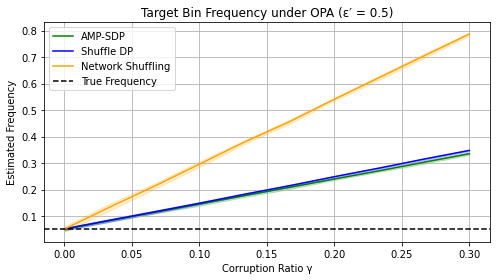

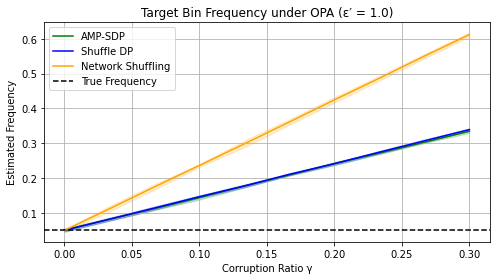

In [15]:
plot_krr()

# Conclusion
This experiment evaluates the robustness of AMP-SDP, Shuffle DP, and Network Shuffling in the context of frequency estimation using the kRR mechanism under Output Poisoning Attacks (OPA).

Key Insights:
- **AMP-SDP** offers strong structural robustness. Since randomized outputs are generated securely post-shuffle, corrupted users cannot directly manipulate reported outputs, making AMP-SDP resistant to OPA.
- **Standard Shuffle DP** is more vulnerable, as OPA can skew frequency estimation by injecting multiple target-bin reports, especially at high corruption rates.
- **Network Shuffling** benefits from weaker amplification (via ε′ = e^{1.5ε₀}/√n), offering weaker accuracy than Shuffle DP in low-to-medium γ ranges, but still inherits OPA vulnerability.

These findings reinforce the value of isolating user-controlled inputs from the final reported signals in adversarial environments.